🌿 WEEK 1 — REAL WORLD ANALYSIS TEMPLATE
Herbal Supplier Quality Control (QC) — Dataset A
# 🌿 Herbal Supplier Quality Control Analysis  
### Week 1 — Real Industry Case Study (Dataset A)

**Role:** Junior Data Scientist – Quality Control  
**Objective:** Evaluate the quality of herbal plant samples received from suppliers and identify patterns in QC failures.

🏭 **Business Problem**
An herbal extraction company receives plant samples from multiple suppliers.
Each batch must be evaluated for:

* Weight consistency
* pH suitability for extraction
* Moisture content (microbial risk)
* Supplier reliability
* Species-level quality differences
              
**The Quality Control (QC) department must determine:**

**Key Questions**
* Which suppliers deliver the most QC failures?
* Which species fail QC most frequently?
* Does sample type (leaf, root, stem, flower) affect quality?
* What is the distribution of pH, weight, and moisture?
* Are there outliers indicating contamination or processing issues?
* What recommendations should QC give to procurement?

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)

In [2]:
#Load Dataset
df = pd.read_csv("Week1_A_Herbal_QC.csv")
df.head()

,sample_id,species,sample_type,supplier_id,weight_mg,pH,moisture_pct,collection_date
0,S0001,Lavandula angustifolia,stem,SUP-A,257.39,5.36,10.03,2025-01-01
1,S0002,Curcuma longa,stem,SUP-A,877.06,7.94,9.22,2025-01-02
2,S0003,Mentha spicata,leaf,SUP-C,384.13,3.91,7.10,2025-01-03
3,S0004,Lavandula angustifolia,stem,SUP-B,808.24,7.79,3.85,2025-01-04
4,S0005,Lavandula angustifolia,leaf,SUP-B,586.47,5.18,15.97,2025-01-05


In [3]:
# Basic Exploration
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        150 non-null    object 
 1   species          150 non-null    object 
 2   sample_type      150 non-null    object 
 3   supplier_id      150 non-null    object 
 4   weight_mg        150 non-null    float64
 5   pH               150 non-null    float64
 6   moisture_pct     150 non-null    float64
 7   collection_date  150 non-null    object 
dtypes: float64(3), object(5)
memory usage: 9.5+ KB


,count,mean,std,min,25%,50%,75%,max
weight_mg,150.0,476.000133,250.396624,62.23,267.085,492.245,666.405,891.55
pH,150.0,6.473867,1.526782,3.85,5.260,6.660,7.820,8.67
moisture_pct,150.0,9.795333,4.177516,3.22,6.110,9.635,12.930,18.00


In [5]:
#Category Checks
df["species"].value_counts().rename_axis("species").reset_index(name = "count"), df["supplier_id"].value_counts().rename_axis("supplier_id").reset_index(name = "count"), df["sample_type"].value_counts().rename_axis("sample_type").reset_index(name = "count")


(                  species  count
 0           Curcuma longa     46
 1  Rosmarinus officinalis     36
 2  Lavandula angustifolia     34
 3          Mentha spicata     34,
   supplier_id  count
 0       SUP-D     53
 1       SUP-C     36
 2       SUP-A     32
 3       SUP-B     29,
   sample_type  count
 0        stem     43
 1        leaf     40
 2      flower     35
 3        root     32)

In [21]:
# categorise the samples according to pH
def ph_category(ph):
    if pd.isna(ph):
        return 'unknown'
    if ph < 6.5:
        return 'acidic'
    if ph <= 7.5:
        return 'neutral'
    else:
        return 'basic'

df['ph_category'] = df['pH'].apply(ph_category)
df['ph_category'].value_counts().rename_axis('ph_categroy').reset_index(name = 'count')

,ph_categroy,count
0,acidic,71
1,basic,49
2,neutral,30


In [22]:
#summarise the Ph categories by the sample type
summary = df.groupby(['sample_type', 'ph_category']).size().rename_axis(['sample_type','ph_category']).reset_index(name = 'count')
summary

,sample_type,ph_category,count
0,flower,acidic,16
1,flower,basic,8
2,flower,neutral,11
3,leaf,acidic,21
4,leaf,basic,18
5,leaf,neutral,1
6,root,acidic,17
7,root,basic,8
8,root,neutral,7
9,stem,acidic,17


In [23]:
#pivot the table for easier interpretation
plot_data = summary.pivot(index = 'sample_type', columns = 'ph_category', values = 'count').fillna(0)
plot_data

ph_category,acidic,basic,neutral
sample_type,,,
flower,16,8,11
leaf,21,18,1
root,17,8,7
stem,17,15,11


In [25]:
#summarise the Ph categories by the species
summary = df.groupby(['species', 'ph_category']).size().rename_axis(['species','ph_category']).reset_index(name = 'count')
summary

,species,ph_category,count
0,Curcuma longa,acidic,23
1,Curcuma longa,basic,15
2,Curcuma longa,neutral,8
3,Lavandula angustifolia,acidic,18
4,Lavandula angustifolia,basic,10
5,Lavandula angustifolia,neutral,6
6,Mentha spicata,acidic,13
7,Mentha spicata,basic,11
8,Mentha spicata,neutral,10
9,Rosmarinus officinalis,acidic,17


In [26]:
#pivot the table for easier interpretation
plot_data = summary.pivot(index = 'species', columns = 'ph_category', values = 'count').fillna(0)
plot_data

ph_category,acidic,basic,neutral
species,,,
Curcuma longa,23,15,8
Lavandula angustifolia,18,10,6
Mentha spicata,13,11,10
Rosmarinus officinalis,17,13,6


#### Define QC Rules
### QC Rules

A sample **fails QC** if ANY of the following are true:

- weight_mg < 100  
- weight_mg > 750  
- pH < 4.5  
- pH > 8.3  
- moisture_pct > 15  

Otherwise → PASS

In [6]:
# Create QC Status Column
def qc_status(row):
    if row["weight_mg"] < 100:
        return "FAIL"
    if row["weight_mg"] > 750:
        return "FAIL"
    if row["pH"] < 4.5:
        return "FAIL"
    if row["pH"] > 8.3:
        return "FAIL"
    if row["moisture_pct"] > 15:
        return "FAIL"
    return "PASS"
df["QC_Status"] = df.apply(qc_status, axis=1)
df.head()

,sample_id,species,sample_type,supplier_id,weight_mg,pH,moisture_pct,collection_date,QC_Status
0,S0001,Lavandula angustifolia,stem,SUP-A,257.39,5.36,10.03,2025-01-01,PASS
1,S0002,Curcuma longa,stem,SUP-A,877.06,7.94,9.22,2025-01-02,FAIL
2,S0003,Mentha spicata,leaf,SUP-C,384.13,3.91,7.10,2025-01-03,FAIL
3,S0004,Lavandula angustifolia,stem,SUP-B,808.24,7.79,3.85,2025-01-04,FAIL
4,S0005,Lavandula angustifolia,leaf,SUP-B,586.47,5.18,15.97,2025-01-05,FAIL


In [27]:
fail_counts = df["QC_Status"].value_counts()
fail_counts

QC_Status
FAIL    90
PASS    60
Name: count, dtype: int64

In [28]:
# QC Failure Overview
failure_rate = (df["QC_Status"].value_counts(normalize=True) * 100).round(2)
failure_rate

QC_Status
FAIL    60.0
PASS    40.0
Name: proportion, dtype: float64

In [29]:
supplier_failures = df.groupby("supplier_id")["QC_Status"].apply(lambda x: (x=="FAIL").sum())
supplier_failures


supplier_id
SUP-A    20
SUP-B    19
SUP-C    19
SUP-D    32
Name: QC_Status, dtype: int64

In [30]:
# Failures by Supplier

supplier_failure_rate = df.groupby("supplier_id")["QC_Status"].apply(lambda x: (x=="FAIL").mean()).round(3)
supplier_failure_rate

supplier_id
SUP-A    0.625
SUP-B    0.655
SUP-C    0.528
SUP-D    0.604
Name: QC_Status, dtype: float64

In [9]:
# Failures by Species
species_failure_rate = df.groupby("species")["QC_Status"].apply(lambda x: (x=="FAIL").mean()).round(3)
species_failure_rate

species
Curcuma longa             0.565
Lavandula angustifolia    0.706
Mentha spicata            0.500
Rosmarinus officinalis    0.639
Name: QC_Status, dtype: float64

In [10]:
# Failures by Sample Type
stype_failure_rate = df.groupby("sample_type")["QC_Status"].apply(lambda x: (x=="FAIL").mean()).round(3)
stype_failure_rate

sample_type
flower    0.514
leaf      0.575
root      0.625
stem      0.674
Name: QC_Status, dtype: float64

 ### Outlier Detection Rules 

A sample is considered an **extreme outlier** if:

- weight_mg < 80 or > 850  
- pH < 4.0 or > 8.6  
- moisture_pct < 3 or > 17 

In [11]:
# Find Outliers
outliers = df[
    (df["weight_mg"] < 80) |
    (df["weight_mg"] > 850) |
    (df["pH"] < 4.0) |
    (df["pH"] > 8.6) |
    (df["moisture_pct"] < 3) |
    (df["moisture_pct"] > 17)
]

outliers.head()

,sample_id,species,sample_type,supplier_id,weight_mg,pH,moisture_pct,collection_date,QC_Status
1,S0002,Curcuma longa,stem,SUP-A,877.06,7.94,9.22,2025-01-02,FAIL
2,S0003,Mentha spicata,leaf,SUP-C,384.13,3.91,7.10,2025-01-03,FAIL
6,S0007,Mentha spicata,stem,SUP-D,477.24,7.21,18.00,2025-01-07,FAIL
7,S0008,Mentha spicata,root,SUP-B,540.37,6.88,17.95,2025-01-08,FAIL
10,S0011,Lavandula angustifolia,stem,SUP-D,664.08,7.74,17.17,2025-01-11,FAIL


In [13]:
 # Outliers by Supplier
outliers.groupby("supplier_id")["sample_id"].count()

supplier_id
SUP-A     5
SUP-B     7
SUP-C     6
SUP-D    16
Name: sample_id, dtype: int64

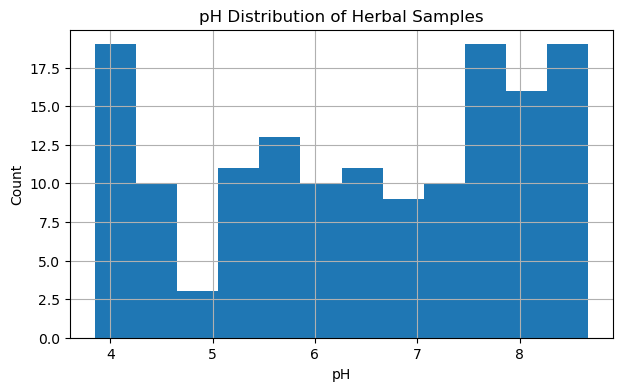

In [14]:
# Visualizations (Histogram of pH)
plt.figure(figsize=(7,4))
plt.hist(df["pH"], bins=12)
plt.title("pH Distribution of Herbal Samples")
plt.xlabel("pH")
plt.ylabel("Count")
plt.grid(True)
plt.show()


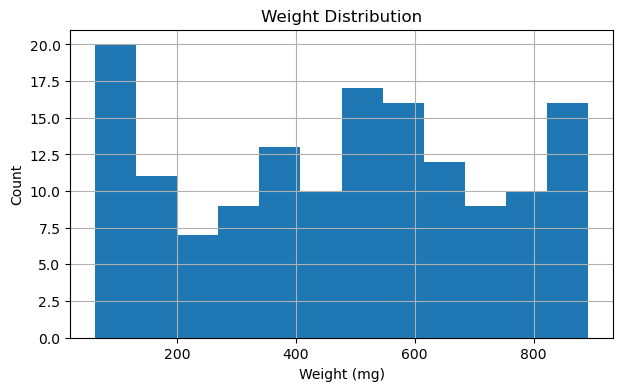

In [15]:
# Histogram of Weights
plt.figure(figsize=(7,4))
plt.hist(df["weight_mg"], bins=12)
plt.title("Weight Distribution")
plt.xlabel("Weight (mg)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

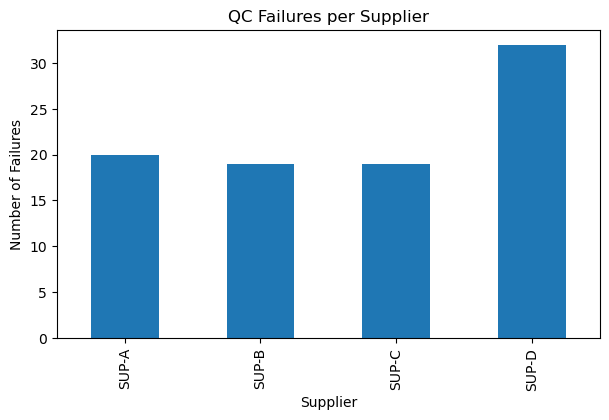

In [16]:
#Failures per Supplier (Bar Chart)
supplier_failures.plot(kind="bar", figsize=(7,4))
plt.title("QC Failures per Supplier")
plt.xlabel("Supplier")
plt.ylabel("Number of Failures")
plt.show()


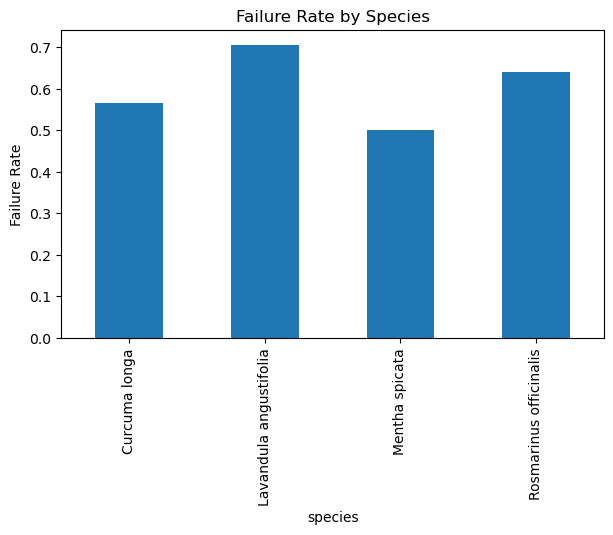

In [17]:

# Failures per Species (Bar Chart)
species_failure_rate.plot(kind="bar", figsize=(7,4))
plt.title("Failure Rate by Species")
plt.ylabel("Failure Rate")
plt.show()

In [18]:

#Summary Statistics Table
summary = df.groupby("supplier_id").agg({
    "weight_mg":"mean",
    "pH":"mean",
    "moisture_pct":"mean"
}).round(2)

summary

,weight_mg,pH,moisture_pct
supplier_id,,,
SUP-A,566.93,6.37,7.84
SUP-B,400.56,6.46,10.20
SUP-C,429.77,6.54,10.87
SUP-D,493.77,6.50,10.02


In [19]:
# Save Outputs
df.to_csv("Week1A_QC_with_results.csv", index=False)
fail_counts.to_csv("Week1A_fail_counts.csv")
supplier_failure_rate.to_csv("Week1A_supplier_failure_rate.csv")

# Final QC Report
## 📄 QC Analysis Report — Herbal Supplier Dataset

## 1. Dataset Overview  

* The dataset has 150 samples in total coming from 4 different suppliers
* The species are *Curcuma longa* with 46 samples
* *Rosmarinus officinalis* with 36 samples
* *Lavandula angustifolia* with 34 samples
* *Mentha spicata* with 34 samples

## 2. QC Failure Summary  
- Total failures:  90 samples
- Failure rate:  60%
- Most common failure reasons: Samples have a high weight possibly due to the presence of contaminants.  

## 3. Supplier Comparison  
The supplier with the most failed samples was SUP-D. 
## 4. Species Comparison  
*Lavundula angustifolia had the highest number of fails.  

## 5. Sample Type Comparison  
Stem samples are the most common samples to fail the QC test. 

## 6. Outlier Analysis  
Supplier SUP-D provided the most outliers with samples having pH higher or lower than the required range. 
This supplier also has the highest weights possibly due to the presence of contaminants. 

## 7. Recommendations  
- Monitor supplier SUP-D 
- Adjust moisture control  
- Reject outlier batches  
- Recalibrate pH before extraction  

